In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from saliency import saliency
import torch
import torchvision.transforms as T
from PIL import Image, ImageSequence
import numpy as np
from utils import saliency_plot
import matplotlib.pyplot as plt

In [3]:
#load pre-trained resnet18
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.eval()

Using cache found in /Users/subrasal/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/subrasal/saj_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/subrasal/saj_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

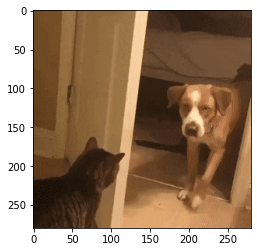

In [5]:
# read gif into tensor
img = Image.open('catdog.gif')
frames_raw = np.array([np.array(frame.copy().convert('RGB').getdata(),dtype=np.uint8).reshape(frame.size[1],frame.size[0],3) for frame in ImageSequence.Iterator(img)])
plt.imshow(frames_raw[0])

#preprocessing for resnet
preprocess = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# preprocessing without normalization
preprocess_preview =  T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
])
frames = np.transpose(frames_raw, (0, 3, 1, 2)).astype(float) #NWHC -> NCWH
frames /= 255
frames = torch.from_numpy(frames)
frames_preview = preprocess_preview(frames)
frames = preprocess(frames)

In [9]:
saliency_plot(torch.permute(frames, (1, 0, 2, 3)).unsqueeze(0), mode="3D", interactive=True)

interactive(children=(IntSlider(value=22, description='Slice:', max=43), Output()), _dom_classes=('widget-inte…

In [19]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]  

In [21]:
categories[162]

'beagle'

In [126]:
pred = model(frames[0].unsqueeze(0))
preds = torch.topk(pred, 5)

In [127]:
for i in preds[1].flatten():
    print(i)
    print(categories[i])

tensor(162)
beagle
tensor(151)
Chihuahua
tensor(180)
American Staffordshire terrier
tensor(227)
kelpie
tensor(811)
space heater


In [6]:
cam = saliency(model.double(), method = "GradCAM", mode="2D", section_names=[["conv1","bn1","relu","maxpool","layer1","layer2","layer3","layer4"],["fc"]], adaptive_layer="avgpool")

In [7]:
_, cams_cat = cam(frames, [281]*len(frames))
_, cams_doggo = cam(frames, [162]*len(frames))

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


In [8]:
vid = torch.permute(frames_preview, (1, 0, 2, 3)).unsqueeze(0)
vid_cam_cat = torch.permute(cams_cat, (1, 0, 2, 3))
vid_cam_doggo = torch.permute(cams_doggo, (1, 0, 2, 3)) 

In [9]:
vid.shape

torch.Size([1, 3, 44, 224, 224])

In [10]:
saliency_plot(vid, [vid_cam_cat, vid_cam_doggo], mode="3D", interactive=True, scale=2, show_cb=True, titles=[None, "ResNet18 prediction for 'tabby'", "ResNet18 prediction for 'beagle'"], show_axis=False)

interactive(children=(IntSlider(value=22, description='Slice:', max=43), Output()), _dom_classes=('widget-inte…

In [115]:
cams.shape

torch.Size([47, 1, 224, 224])

In [97]:
cams[

tensor([[[0.0097, 0.0097, 0.0097,  ..., 0.0000, 0.0000, 0.0000],
         [0.0097, 0.0097, 0.0097,  ..., 0.0000, 0.0000, 0.0000],
         [0.0097, 0.0097, 0.0097,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       grad_fn=<SelectBackward0>)

In [72]:
import glob
gif_in = "./*.png"
gif_out = "output_example.gif"

imgs = (Image.open(f) for f in sorted(glob.glob(gif_in), key=lambda i: int(i.replace(".", "").replace("/", "").replace("png", ""))))
img = next(imgs)
img.save(fp=gif_out, format="GIF", append_images=imgs, save_all=True, duration=100, loop=2)

In [47]:
imgs

<generator object <genexpr> at 0x7fe970782f20>

In [63]:
b = [int(i.replace(".", "").replace("/", "").replace("png", "")) for i in glob.glob(gif_in)]

In [68]:
a

['./0.png',
 './1.png',
 './2.png',
 './3.png',
 './4.png',
 './5.png',
 './6.png',
 './7.png',
 './8.png',
 './9.png',
 './10.png',
 './11.png',
 './12.png',
 './13.png',
 './14.png',
 './15.png',
 './16.png',
 './17.png',
 './18.png',
 './19.png',
 './20.png',
 './21.png',
 './22.png',
 './23.png',
 './24.png',
 './25.png',
 './26.png',
 './27.png',
 './28.png',
 './29.png',
 './30.png',
 './31.png',
 './32.png',
 './33.png',
 './34.png',
 './35.png',
 './36.png',
 './37.png',
 './38.png',
 './39.png',
 './40.png',
 './41.png',
 './42.png',
 './43.png']

In [54]:
[int(i) for i.split() in a]

SyntaxError: cannot assign to function call (3873586802.py, line 1)

In [58]:
"asdf.png".replace(".", "").

'asdfpng'

In [61]:
[int(i.replace(".", "").replace("/", "").replace("png", "")) for i in a]

[0,
 1,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 2,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 3,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 4,
 40,
 41,
 42,
 43,
 5,
 6,
 7,
 8,
 9]